# Normalizing flows:  re-implementation of the Glow paper

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import utils
import nets
import flow_layers as fl

In [3]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

## Import dataset

In [4]:
batch_size = 32
image_size = 24
x_train_samples = utils.create_tfrecord_dataset_iterator(
    "datasets/celeba/celeba_train.tfrecords", batch_size=batch_size, image_size=image_size
)

x_train_samples

<tf.Tensor 'truediv:0' shape=(32, 24, 24, 3) dtype=float32>

### Check shapes (initial call will take a while)

In [5]:
x_train_samples.eval().shape

(32, 24, 24, 3)

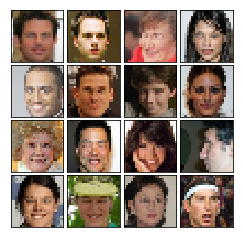

In [6]:
utils.plot_4x4_grid(x_train_samples.eval(), shape=[image_size, image_size, 3])

In [7]:
%timeit -n 100 x_train_samples.eval()

3.48 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Build Flow with Resnet blocks 

In [8]:
nn_template_fn = nets.ResentTemplate(
    units_factor=8, num_blocks=1
)

nn_openai_template_fn = nets.OpenAITemplate(
    width=128
)

* the more steps the better. At th begining I have tried with num_steps=1, or 2 but model was not learning at all

In [9]:
layers, actnorm_layers = nets.create_simple_flow(
    num_steps=8, 
    num_scales=3, 
    template_fn=nn_template_fn
)

# create model
images = x_train_samples
flow = fl.InputLayer(images)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

LogitifyImage/Forward/                  : x=[32, 24, 24, 3]	z=[None]	logdet=[32]
SqueezingLayer/Forward/Scale1           : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormBiasLayer/Forward/               : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormScaleLayer/Forward/              : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormLayer/Forward/                   : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
InvertibleConv1x1Layer/Forward/         : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
AffineCouplingLayer/Forward/            : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ChainLayer/Forward/Step1                : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormBiasLayer/Forward/               : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormScaleLayer/Forward/              : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 12, 12, 12]	z=[None]	logdet=[32]
ActnormLayer/Forw

ActnormScaleLayer/Forward/              : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormLayer/Forward/                   : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
InvertibleConv1x1Layer/Forward/         : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
AffineCouplingLayer/Forward/            : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Forward/Step7                : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormBiasLayer/Forward/               : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormScaleLayer/Forward/              : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormLayer/Forward/                   : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
InvertibleConv1x1Layer/Forward/         : x=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
AffineCouplingLayer/Forward/    

## Prepare output tensors

In [10]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer/outputs/x:0' shape=(32, 3, 3, 24) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/lodget:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/z:0' shape=(32, 3, 3, 168) dtype=float32>)

## Build loss function

* Here simply the $-logp(x)$

In [11]:
tfd = tf.contrib.distributions

beta_ph = tf.placeholder(tf.float32, [])

y_flatten = tf.reshape(y, [batch_size, -1])
z_flatten = tf.reshape(z, [batch_size, -1])

prior_y = tfd.MultivariateNormalDiag(loc=tf.zeros_like(y_flatten), scale_diag=beta_ph * tf.ones_like(y_flatten))
prior_z = tfd.MultivariateNormalDiag(loc=tf.zeros_like(z_flatten), scale_diag=beta_ph * tf.ones_like(z_flatten))

log_prob_y =  prior_y.log_prob(y_flatten)
log_prob_z =  prior_z.log_prob(z_flatten)

In [12]:
prior_z

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=(32,) event_shape=(1512,) dtype=float32>

### The MLE loss

In [13]:
loss = log_prob_y + log_prob_z + logdet
loss = - tf.reduce_mean(loss)

### The L2 regularization loss 

In [14]:
trainable_variables = tf.trainable_variables() 
l2_reg = 0.0001 
l2_loss = l2_reg * tf.add_n([ tf.nn.l2_loss(v) for v in trainable_variables])

### Debug model, print variables 

In [15]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
#     print(f"[{k:4}][{num_params:6}] {v.op.name[:96]}")

print(f"total_params: {total_params/1e6} M")

total_params: 4.520208 M


### Total loss -logp(x) + l2_loss

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
total_loss = l2_loss + loss

In [18]:
l2_loss.eval(feed_dict={beta_ph: 1.0}), loss.eval(feed_dict={beta_ph: 1.0})

(0.46844378, 894.0392)

## Create backward flow to generate samples

In [19]:
sample_y_flatten = prior_y.sample()
sample_y = tf.reshape(sample_y_flatten, y.shape.as_list())
sample_z = tf.reshape(prior_z.sample(), z.shape.as_list())
sampled_logdet = prior_y.log_prob(sample_y_flatten)

In [20]:
inverse_flow = sample_y, sampled_logdet, sample_z
sampled_flow = model_flow(inverse_flow, forward=False)

FactorOutLayer/Backward/Scale3          : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ChainLayer/Backward/Step8               : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 48]	z=[32, 3, 3, 144]	logdet=[32]
ActnormBiasLayer/Back

AffineCouplingLayer/Backward/           : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Backward/Step2               : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 6, 6, 24]	z=[32, 6, 6, 24]	logdet=[32]
ChainLayer/Backward/            

In [21]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
print(f"total_params: {total_params/1e6} M")

total_params: 4.520208 M


In [22]:
x_flow_sampled, _, _ = sampled_flow

In [23]:
x_flow_sampled.eval({beta_ph: 1.0}).shape

(32, 24, 24, 3)

## Define optimizer and learning rate

In [24]:
lr_ph = tf.placeholder(tf.float32)

optimizer = tf.train.AdamOptimizer(lr_ph)
train_op = optimizer.minimize(total_loss)

## Initialize Actnorms using DDI

In [25]:
sess.run(tf.global_variables_initializer())
nets.initialize_actnorms(
    sess,
    feed_dict_fn=lambda: {beta_ph: 1.0},
    actnorm_layers=actnorm_layers,
    num_steps=50,
)

100%|██████████| 24/24 [00:31<00:00,  1.33s/it]


In [49]:
for layer in actnorm_layers:
    init_op = layer.get_ddi_init_ops(30)
    tf.add_to_collection("ACTNORMS_INIT_OPS", init_op)

In [50]:
tf.get_collection("ACTNORMS_INIT_OPS")

[<tf.Operation 'group_deps_24' type=NoOp>,
 <tf.Operation 'group_deps_25' type=NoOp>,
 <tf.Operation 'group_deps_26' type=NoOp>,
 <tf.Operation 'group_deps_27' type=NoOp>,
 <tf.Operation 'group_deps_28' type=NoOp>,
 <tf.Operation 'group_deps_29' type=NoOp>,
 <tf.Operation 'group_deps_30' type=NoOp>,
 <tf.Operation 'group_deps_31' type=NoOp>,
 <tf.Operation 'group_deps_32' type=NoOp>,
 <tf.Operation 'group_deps_33' type=NoOp>,
 <tf.Operation 'group_deps_34' type=NoOp>,
 <tf.Operation 'group_deps_35' type=NoOp>,
 <tf.Operation 'group_deps_36' type=NoOp>,
 <tf.Operation 'group_deps_37' type=NoOp>,
 <tf.Operation 'group_deps_38' type=NoOp>,
 <tf.Operation 'group_deps_39' type=NoOp>,
 <tf.Operation 'group_deps_40' type=NoOp>,
 <tf.Operation 'group_deps_41' type=NoOp>,
 <tf.Operation 'group_deps_42' type=NoOp>,
 <tf.Operation 'group_deps_43' type=NoOp>,
 <tf.Operation 'group_deps_44' type=NoOp>,
 <tf.Operation 'group_deps_45' type=NoOp>,
 <tf.Operation 'group_deps_46' type=NoOp>,
 <tf.Operat

## Train model, define metrics and trainer

In [29]:
metrics = utils.Metrics(50, metrics_tensors={"total_loss": total_loss, "loss": loss, "l2_loss": l2_loss})
plot_metrics_hook = utils.PlotMetricsHook(metrics, step=1000)

In [30]:
sess.run(train_op, feed_dict={lr_ph: 0.0, beta_ph: 1.0})

In [31]:
total_loss.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})

-1118.501

### Initial samples from model

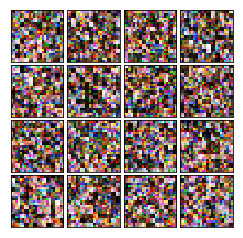

In [32]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.001

  5%|▌         | 50/1000 [00:04<01:29, 10.60it/s]

total_loss -4003.2742
loss -4006.2056
l2_loss 2.9314387


 10%|█         | 102/1000 [00:09<01:23, 10.76it/s]

total_loss -3892.441
loss -3895.3723
l2_loss 2.9314258


 15%|█▌        | 150/1000 [00:13<01:19, 10.74it/s]

total_loss -4013.0232
loss -4015.9546
l2_loss 2.9314141


 20%|██        | 202/1000 [00:18<01:14, 10.75it/s]

total_loss -3828.9802
loss -3831.9116
l2_loss 2.9314024


 25%|██▌       | 252/1000 [00:23<01:08, 10.87it/s]

total_loss -3961.3567
loss -3964.288
l2_loss 2.9313948


 30%|███       | 302/1000 [00:27<01:04, 10.84it/s]

total_loss -4026.955
loss -4029.8865
l2_loss 2.9313848


 35%|███▌      | 352/1000 [00:32<00:59, 10.83it/s]

total_loss -3895.4934
loss -3898.4248
l2_loss 2.9313738


 40%|████      | 402/1000 [00:37<00:55, 10.84it/s]

total_loss -4117.6704
loss -4120.6016
l2_loss 2.9313695


 45%|████▌     | 452/1000 [00:41<00:50, 10.83it/s]

total_loss -3759.1775
loss -3762.109
l2_loss 2.9313686


 50%|█████     | 502/1000 [00:46<00:45, 10.84it/s]

total_loss -3893.4133
loss -3896.3447
l2_loss 2.9313703


 55%|█████▌    | 552/1000 [00:51<00:41, 10.82it/s]

total_loss -3978.9438
loss -3981.8752
l2_loss 2.9313686


 60%|██████    | 602/1000 [00:55<00:36, 10.84it/s]

total_loss -4000.9614
loss -4003.8928
l2_loss 2.9313657


 65%|██████▌   | 652/1000 [01:00<00:32, 10.85it/s]

total_loss -3947.8254
loss -3950.7568
l2_loss 2.9313579


 70%|███████   | 702/1000 [01:04<00:27, 10.83it/s]

total_loss -3973.657
loss -3976.5884
l2_loss 2.931345


 75%|███████▌  | 751/1000 [01:09<00:22, 10.83it/s]

total_loss -3944.1577
loss -3947.089
l2_loss 2.9313362


 80%|████████  | 801/1000 [01:13<00:18, 10.83it/s]

total_loss -3790.6418
loss -3793.5732
l2_loss 2.9313262


 85%|████████▌ | 851/1000 [01:18<00:13, 10.82it/s]

total_loss -3965.3782
loss -3968.3096
l2_loss 2.9313192


 90%|█████████ | 901/1000 [01:23<00:09, 10.82it/s]

total_loss -3895.3982
loss -3898.3296
l2_loss 2.931311


 95%|█████████▌| 951/1000 [01:27<00:04, 10.82it/s]

total_loss -3965.4404
loss -3968.3718
l2_loss 2.9313061


100%|█████████▉| 999/1000 [01:32<00:00, 10.82it/s]

total_loss -3912.3154
loss -3915.2468
l2_loss 2.9313016


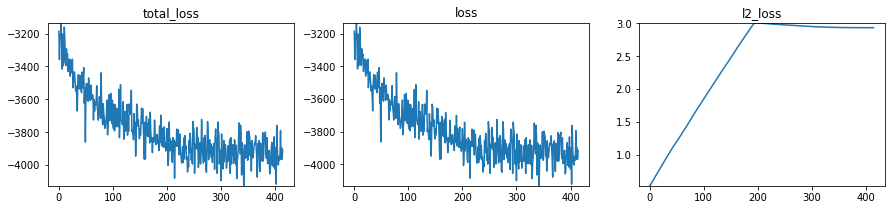

100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]


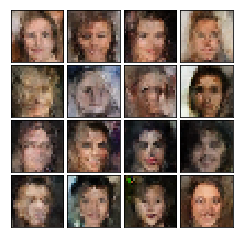

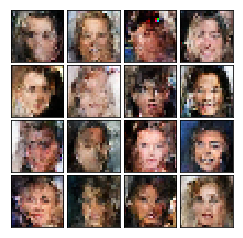

  5%|▌         | 52/1000 [00:04<01:24, 11.28it/s]

total_loss -4030.3877
loss -4033.319
l2_loss 2.9313002


 10%|█         | 102/1000 [00:09<01:20, 11.20it/s]

total_loss -3999.8123
loss -4002.7437
l2_loss 2.9312966


 15%|█▌        | 150/1000 [00:13<01:16, 11.08it/s]

total_loss -3864.257
loss -3867.1885
l2_loss 2.9312956


 20%|██        | 200/1000 [00:18<01:12, 11.03it/s]

total_loss -4078.8496
loss -4081.781
l2_loss 2.9312959


 25%|██▌       | 252/1000 [00:22<01:08, 10.96it/s]

total_loss -4055.7576
loss -4058.689
l2_loss 2.9312904


 30%|███       | 300/1000 [00:27<01:04, 10.93it/s]

total_loss -3922.66
loss -3925.5913
l2_loss 2.9312809


 35%|███▌      | 350/1000 [00:32<00:59, 10.92it/s]

total_loss -3944.4312
loss -3947.3623
l2_loss 2.9312692


 40%|████      | 402/1000 [00:36<00:55, 10.87it/s]

total_loss -4108.0864
loss -4111.0176
l2_loss 2.9312572


 45%|████▌     | 452/1000 [00:41<00:50, 10.94it/s]

total_loss -3837.0916
loss -3840.0227
l2_loss 2.9312475


 50%|█████     | 502/1000 [00:45<00:45, 10.98it/s]

total_loss -3913.7095
loss -3916.6406
l2_loss 2.93124


 55%|█████▌    | 552/1000 [00:50<00:40, 11.04it/s]

total_loss -3881.7627
loss -3884.6938
l2_loss 2.9312334


 60%|██████    | 602/1000 [00:54<00:35, 11.12it/s]

total_loss -4045.9785
loss -4048.9097
l2_loss 2.931226


 65%|██████▌   | 652/1000 [00:58<00:31, 11.16it/s]

total_loss -3929.1125
loss -3932.0437
l2_loss 2.9312239


 70%|███████   | 702/1000 [01:02<00:26, 11.19it/s]

total_loss -3924.142
loss -3927.0732
l2_loss 2.9312193


 75%|███████▌  | 752/1000 [01:06<00:22, 11.23it/s]

total_loss -4031.5063
loss -4034.4375
l2_loss 2.9312189


 80%|████████  | 802/1000 [01:11<00:17, 11.27it/s]

total_loss -3909.0977
loss -3912.0288
l2_loss 2.9312184


 85%|████████▌ | 852/1000 [01:15<00:13, 11.31it/s]

total_loss -4035.9458
loss -4038.877
l2_loss 2.9312162


 90%|█████████ | 902/1000 [01:19<00:08, 11.32it/s]

total_loss -3986.0776
loss -3989.0088
l2_loss 2.9312065


 95%|█████████▌| 952/1000 [01:23<00:04, 11.36it/s]

total_loss -3732.0178
loss -3734.949
l2_loss 2.931193


100%|█████████▉| 998/1000 [01:27<00:00, 11.38it/s]

total_loss -4023.937
loss -4026.8682
l2_loss 2.9311845


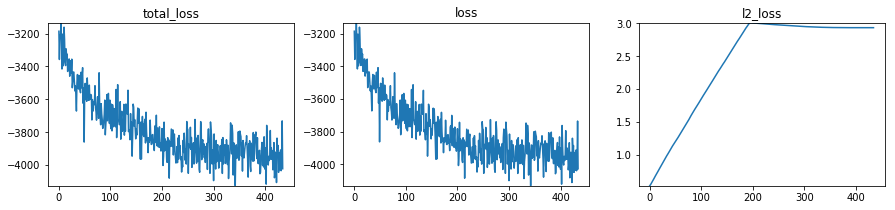

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


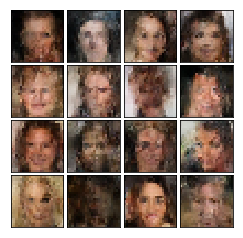

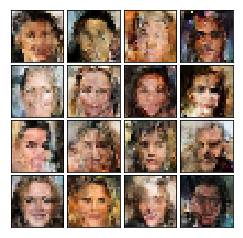

  5%|▌         | 52/1000 [00:04<01:19, 11.86it/s]

total_loss -3883.7092
loss -3886.6404
l2_loss 2.9311738


 10%|█         | 102/1000 [00:08<01:14, 12.00it/s]

total_loss -3946.4448
loss -3949.376
l2_loss 2.9311688


 15%|█▌        | 152/1000 [00:12<01:10, 11.98it/s]

total_loss -3770.2957
loss -3773.2268
l2_loss 2.9311585


 20%|██        | 202/1000 [00:16<01:06, 11.92it/s]

total_loss -4017.8022
loss -4020.7334
l2_loss 2.9311504


 25%|██▌       | 252/1000 [00:21<01:03, 11.86it/s]

total_loss -3942.4773
loss -3945.4084
l2_loss 2.9311447


 30%|███       | 302/1000 [00:25<00:58, 11.84it/s]

total_loss -3944.3804
loss -3947.3115
l2_loss 2.9311428


 35%|███▌      | 352/1000 [00:29<00:54, 11.86it/s]

total_loss -4026.6602
loss -4029.5913
l2_loss 2.93114


 40%|████      | 402/1000 [00:33<00:50, 11.88it/s]

total_loss -4050.0356
loss -4052.9668
l2_loss 2.9311407


 45%|████▌     | 452/1000 [00:37<00:46, 11.90it/s]

total_loss -4049.7651
loss -4052.6963
l2_loss 2.9311407


 50%|█████     | 502/1000 [00:42<00:41, 11.91it/s]

total_loss -3894.565
loss -3897.496
l2_loss 2.9311342


 55%|█████▌    | 552/1000 [00:46<00:37, 11.94it/s]

total_loss -4004.9534
loss -4007.8845
l2_loss 2.9311213


 60%|██████    | 602/1000 [00:50<00:33, 11.93it/s]

total_loss -3962.4229
loss -3965.354
l2_loss 2.931109


 65%|██████▌   | 652/1000 [00:54<00:29, 11.91it/s]

total_loss -3935.6543
loss -3938.5854
l2_loss 2.9310963


 70%|███████   | 702/1000 [00:58<00:24, 11.93it/s]

total_loss -3980.9443
loss -3983.8755
l2_loss 2.9310892


 75%|███████▌  | 752/1000 [01:02<00:20, 11.94it/s]

total_loss -3978.851
loss -3981.7822
l2_loss 2.9310815


 80%|████████  | 802/1000 [01:07<00:16, 11.94it/s]

total_loss -4022.9575
loss -4025.8887
l2_loss 2.9310703


 85%|████████▌ | 852/1000 [01:11<00:12, 11.94it/s]

total_loss -3929.7407
loss -3932.6719
l2_loss 2.9310615


 90%|█████████ | 902/1000 [01:15<00:08, 11.94it/s]

total_loss -3952.0088
loss -3954.94
l2_loss 2.9310572


 95%|█████████▌| 952/1000 [01:19<00:04, 11.93it/s]

total_loss -3912.5112
loss -3915.4424
l2_loss 2.9310572


100%|█████████▉| 998/1000 [01:23<00:00, 11.90it/s]

total_loss -4040.604
loss -4043.5352
l2_loss 2.9310584


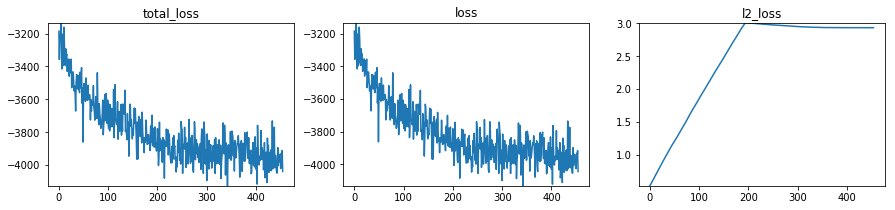

100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


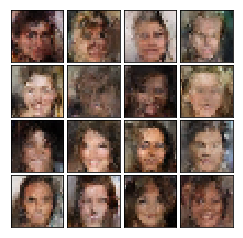

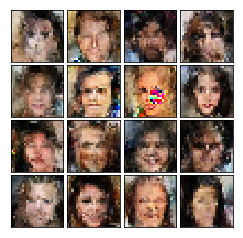

  5%|▌         | 51/1000 [00:04<01:25, 11.12it/s]

total_loss -3839.462
loss -3842.393
l2_loss 2.9310596


 10%|█         | 101/1000 [00:09<01:22, 10.87it/s]

total_loss -3811.724
loss -3814.6553
l2_loss 2.9310536


 15%|█▌        | 151/1000 [00:13<01:17, 10.93it/s]

total_loss -3869.6013
loss -3872.5325
l2_loss 2.9310455


 20%|██        | 201/1000 [00:18<01:13, 10.91it/s]

total_loss -3971.2188
loss -3974.15
l2_loss 2.9310343


 25%|██▌       | 251/1000 [00:23<01:08, 10.90it/s]

total_loss -3867.7417
loss -3870.6726
l2_loss 2.9310236


 30%|███       | 301/1000 [00:27<01:04, 10.91it/s]

total_loss -3921.6228
loss -3924.5537
l2_loss 2.931013


 35%|███▌      | 351/1000 [00:32<00:59, 10.92it/s]

total_loss -4013.5862
loss -4016.517
l2_loss 2.931006


 40%|████      | 401/1000 [00:36<00:54, 10.94it/s]

total_loss -3927.5476
loss -3930.4785
l2_loss 2.9309976


 45%|████▌     | 451/1000 [00:41<00:50, 10.96it/s]

total_loss -4054.8381
loss -4057.769
l2_loss 2.9309864


 50%|█████     | 501/1000 [00:45<00:45, 10.94it/s]

total_loss -4035.3596
loss -4038.2905
l2_loss 2.9309838


 55%|█████▌    | 551/1000 [00:50<00:41, 10.91it/s]

total_loss -3942.889
loss -3945.8198
l2_loss 2.9309807


 60%|██████    | 601/1000 [00:55<00:36, 10.89it/s]

total_loss -3849.738
loss -3852.669
l2_loss 2.9309745


 65%|██████▌   | 651/1000 [00:59<00:32, 10.88it/s]

total_loss -3906.6926
loss -3909.6235
l2_loss 2.9309778


 70%|███████   | 701/1000 [01:04<00:27, 10.87it/s]

total_loss -3708.073
loss -3711.004
l2_loss 2.9309752


 75%|███████▌  | 751/1000 [01:09<00:22, 10.87it/s]

total_loss -3888.6653
loss -3891.5962
l2_loss 2.930972


 80%|████████  | 801/1000 [01:13<00:18, 10.87it/s]

total_loss -3938.7566
loss -3941.6875
l2_loss 2.9309602


 85%|████████▌ | 852/1000 [01:18<00:13, 10.86it/s]

total_loss -3956.381
loss -3959.312
l2_loss 2.9309487


 90%|█████████ | 902/1000 [01:23<00:09, 10.85it/s]

total_loss -4029.2805
loss -4032.2114
l2_loss 2.9309378


 95%|█████████▌| 952/1000 [01:27<00:04, 10.87it/s]

total_loss -3974.6565
loss -3977.5874
l2_loss 2.93093


100%|█████████▉| 998/1000 [01:31<00:00, 10.87it/s]

total_loss -3872.7952
loss -3875.726
l2_loss 2.9309208


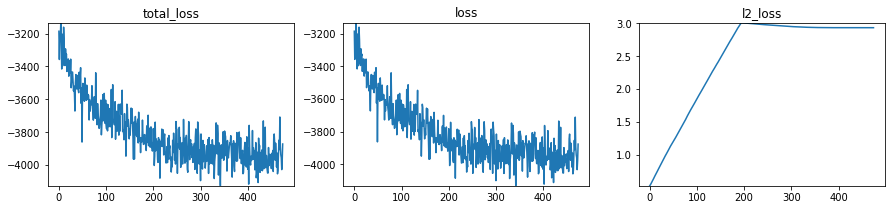

100%|██████████| 1000/1000 [01:32<00:00, 10.83it/s]


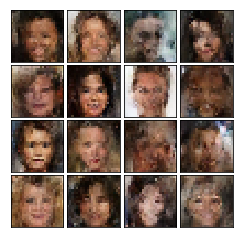

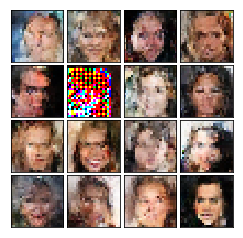

  5%|▌         | 51/1000 [00:04<01:20, 11.72it/s]

total_loss -4020.429
loss -4023.3599
l2_loss 2.9309103


 10%|█         | 101/1000 [00:08<01:19, 11.32it/s]

total_loss -3705.8472
loss -3708.778
l2_loss 2.9309042


 15%|█▌        | 151/1000 [00:13<01:16, 11.10it/s]

total_loss -3948.1667
loss -3951.0977
l2_loss 2.9309025


 20%|██        | 201/1000 [00:18<01:12, 11.03it/s]

total_loss -3815.8574
loss -3818.7883
l2_loss 2.9309015


 25%|██▌       | 251/1000 [00:22<01:08, 11.01it/s]

total_loss -4032.9094
loss -4035.8403
l2_loss 2.9309044


 30%|███       | 301/1000 [00:27<01:03, 11.02it/s]

total_loss -3872.507
loss -3875.438
l2_loss 2.9309049


 35%|███▌      | 351/1000 [00:31<00:58, 11.01it/s]

total_loss -3998.9434
loss -4001.8743
l2_loss 2.9308975


 40%|████      | 401/1000 [00:36<00:54, 11.02it/s]

total_loss -4020.8901
loss -4023.821
l2_loss 2.9308898


 45%|████▌     | 451/1000 [00:40<00:49, 11.02it/s]

total_loss -3785.3352
loss -3788.266
l2_loss 2.9308755


 50%|█████     | 501/1000 [00:45<00:45, 11.03it/s]

total_loss -3938.9097
loss -3941.8406
l2_loss 2.9308653


 55%|█████▌    | 551/1000 [00:50<00:40, 11.02it/s]

total_loss -3974.8274
loss -3977.7583
l2_loss 2.9308553


 60%|██████    | 601/1000 [00:54<00:36, 11.02it/s]

total_loss -3867.4385
loss -3870.3694
l2_loss 2.9308467


 65%|██████▌   | 651/1000 [00:59<00:31, 11.03it/s]

total_loss -3899.7056
loss -3902.6365
l2_loss 2.930842


 70%|███████   | 701/1000 [01:03<00:27, 11.03it/s]

total_loss -3911.197
loss -3914.128
l2_loss 2.9308326


 75%|███████▌  | 751/1000 [01:08<00:22, 11.02it/s]

total_loss -3975.4678
loss -3978.3987
l2_loss 2.9308274


 80%|████████  | 801/1000 [01:12<00:18, 11.01it/s]

total_loss -3941.8835
loss -3944.8145
l2_loss 2.9308252


 85%|████████▌ | 851/1000 [01:17<00:13, 11.00it/s]

total_loss -3767.7166
loss -3770.6475
l2_loss 2.9308252


 90%|█████████ | 901/1000 [01:22<00:09, 10.98it/s]

total_loss -3856.0144
loss -3858.9453
l2_loss 2.930826


 95%|█████████▌| 951/1000 [01:26<00:04, 10.97it/s]

total_loss -3872.3064
loss -3875.2373
l2_loss 2.9308224


100%|█████████▉| 999/1000 [01:31<00:00, 10.97it/s]

total_loss -3945.5566
loss -3948.4875
l2_loss 2.9308164


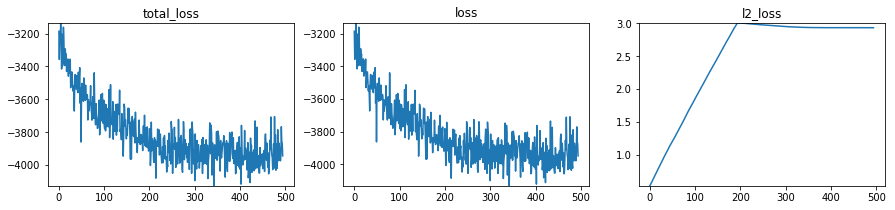

100%|██████████| 1000/1000 [01:31<00:00, 10.91it/s]


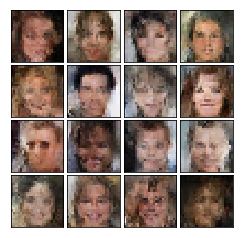

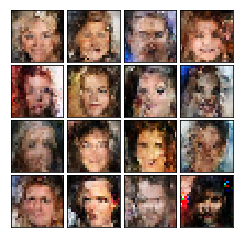

  5%|▌         | 52/1000 [00:04<01:25, 11.11it/s]

total_loss -3813.541
loss -3816.472
l2_loss 2.9308069


 10%|█         | 102/1000 [00:09<01:20, 11.17it/s]

total_loss -3902.8792
loss -3905.81
l2_loss 2.9307973


 15%|█▌        | 152/1000 [00:13<01:16, 11.04it/s]

total_loss -3701.5063
loss -3704.4373
l2_loss 2.9307907


 20%|██        | 202/1000 [00:18<01:13, 10.89it/s]

total_loss -4079.6375
loss -4082.568
l2_loss 2.9307833


 25%|██▌       | 250/1000 [00:22<01:08, 10.92it/s]

total_loss -3979.1519
loss -3982.0825
l2_loss 2.930778


 30%|███       | 302/1000 [00:27<01:04, 10.87it/s]

total_loss -3960.318
loss -3963.2488
l2_loss 2.9307725


 35%|███▌      | 352/1000 [00:32<00:59, 10.84it/s]

total_loss -4059.1582
loss -4062.0889
l2_loss 2.930766


 40%|████      | 402/1000 [00:37<00:55, 10.85it/s]

total_loss -3890.571
loss -3893.5017
l2_loss 2.930766


 45%|████▌     | 452/1000 [00:41<00:50, 10.86it/s]

total_loss -3880.1606
loss -3883.0913
l2_loss 2.9307654


 50%|█████     | 502/1000 [00:46<00:45, 10.88it/s]

total_loss -3855.2512
loss -3858.182
l2_loss 2.930768


 55%|█████▌    | 552/1000 [00:50<00:41, 10.88it/s]

total_loss -3889.688
loss -3892.6187
l2_loss 2.930766


 60%|██████    | 602/1000 [00:55<00:36, 10.86it/s]

total_loss -3699.901
loss -3702.8315
l2_loss 2.9307647


 65%|██████▌   | 652/1000 [01:00<00:32, 10.85it/s]

total_loss -4056.5493
loss -4059.48
l2_loss 2.9307606


 70%|███████   | 702/1000 [01:04<00:27, 10.87it/s]

total_loss -3769.0588
loss -3771.9895
l2_loss 2.9307473


 75%|███████▌  | 752/1000 [01:09<00:22, 10.88it/s]

total_loss -3950.8362
loss -3953.7668
l2_loss 2.9307373


 80%|████████  | 802/1000 [01:13<00:18, 10.89it/s]

total_loss -3967.1829
loss -3970.1135
l2_loss 2.9307313


 85%|████████▌ | 852/1000 [01:18<00:13, 10.92it/s]

total_loss -3963.2803
loss -3966.211
l2_loss 2.9307277


 90%|█████████ | 901/1000 [01:22<00:09, 10.90it/s]

total_loss -3875.2036
loss -3878.1343
l2_loss 2.9307218


 95%|█████████▌| 951/1000 [01:27<00:04, 10.90it/s]

total_loss -4094.496
loss -4097.427
l2_loss 2.930718


100%|█████████▉| 998/1000 [01:31<00:00, 10.89it/s]

total_loss -3951.3982
loss -3954.3289
l2_loss 2.930717


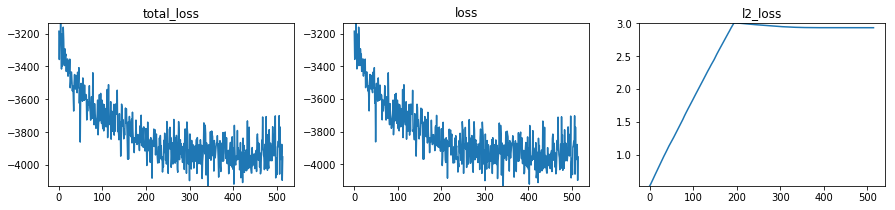

100%|██████████| 1000/1000 [01:32<00:00, 10.75it/s]


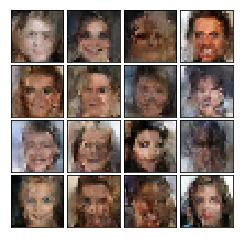

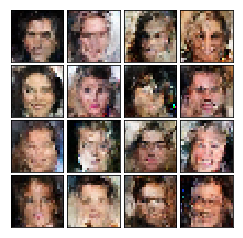

  5%|▌         | 51/1000 [00:04<01:25, 11.11it/s]

total_loss -4004.4492
loss -4007.38
l2_loss 2.9307153


 10%|█         | 101/1000 [00:09<01:22, 10.96it/s]

total_loss -4008.7026
loss -4011.6333
l2_loss 2.9307165


 15%|█▌        | 151/1000 [00:13<01:17, 10.92it/s]

total_loss -3855.7148
loss -3858.6455
l2_loss 2.9307177


 20%|██        | 201/1000 [00:18<01:13, 10.87it/s]

total_loss -3835.1958
loss -3838.1265
l2_loss 2.9307172


 25%|██▌       | 251/1000 [00:23<01:09, 10.85it/s]

total_loss -3986.026
loss -3988.9565
l2_loss 2.930715


 30%|███       | 301/1000 [00:27<01:04, 10.90it/s]

total_loss -3824.265
loss -3827.1956
l2_loss 2.930708


 35%|███▌      | 351/1000 [00:32<00:59, 10.90it/s]

total_loss -3917.8901
loss -3920.8208
l2_loss 2.9307


 40%|████      | 401/1000 [00:36<00:54, 10.89it/s]

total_loss -3987.871
loss -3990.8018
l2_loss 2.9306934


 45%|████▌     | 451/1000 [00:41<00:50, 10.91it/s]

total_loss -3874.8477
loss -3877.7783
l2_loss 2.9306886


 50%|█████     | 501/1000 [00:45<00:45, 10.90it/s]

total_loss -4029.9382
loss -4032.869
l2_loss 2.9306853


 55%|█████▌    | 551/1000 [00:50<00:41, 10.90it/s]

total_loss -3923.5527
loss -3926.4834
l2_loss 2.9306777


 60%|██████    | 601/1000 [00:55<00:36, 10.90it/s]

total_loss -3889.5781
loss -3892.5088
l2_loss 2.930675


 65%|██████▌   | 651/1000 [00:59<00:32, 10.88it/s]

total_loss -3887.041
loss -3889.9717
l2_loss 2.9306724


 70%|███████   | 701/1000 [01:04<00:27, 10.87it/s]

total_loss -3956.7998
loss -3959.7305
l2_loss 2.9306753


 75%|███████▌  | 751/1000 [01:09<00:22, 10.88it/s]

total_loss -4061.7302
loss -4064.661
l2_loss 2.9306772


 80%|████████  | 801/1000 [01:13<00:18, 10.91it/s]

total_loss -3925.0557
loss -3927.9863
l2_loss 2.9306798


 85%|████████▌ | 851/1000 [01:17<00:13, 10.91it/s]

total_loss -3866.7974
loss -3869.728
l2_loss 2.9306781


 90%|█████████ | 901/1000 [01:22<00:09, 10.93it/s]

total_loss -4132.0464
loss -4134.977
l2_loss 2.930672


 95%|█████████▌| 951/1000 [01:26<00:04, 10.95it/s]

total_loss -3991.115
loss -3994.0457
l2_loss 2.9306633


100%|█████████▉| 999/1000 [01:31<00:00, 10.95it/s]

total_loss -3987.3237
loss -3990.2544
l2_loss 2.930655


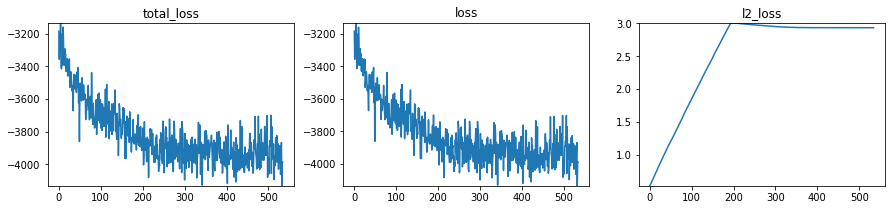

100%|██████████| 1000/1000 [01:31<00:00, 10.90it/s]


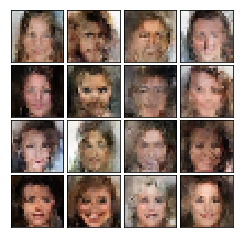

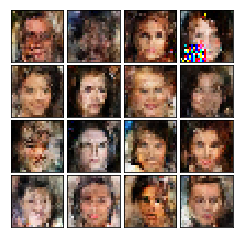

  5%|▌         | 51/1000 [00:04<01:23, 11.30it/s]

total_loss -3964.6367
loss -3967.5674
l2_loss 2.9306514


 10%|█         | 101/1000 [00:09<01:20, 11.12it/s]

total_loss -3980.392
loss -3983.3228
l2_loss 2.9306457


 15%|█▌        | 151/1000 [00:13<01:17, 10.98it/s]

total_loss -3954.166
loss -3957.0967
l2_loss 2.9306402


 20%|██        | 201/1000 [00:18<01:13, 10.94it/s]

total_loss -3820.8926
loss -3823.8232
l2_loss 2.9306371


 25%|██▌       | 251/1000 [00:22<01:08, 11.01it/s]

total_loss -3937.9893
loss -3940.92
l2_loss 2.9306374


 30%|███       | 302/1000 [00:28<01:05, 10.72it/s]

total_loss -4009.4634
loss -4012.394
l2_loss 2.9306414


 35%|███▌      | 352/1000 [00:32<01:00, 10.76it/s]

total_loss -3750.514
loss -3753.4446
l2_loss 2.9306402


 40%|████      | 400/1000 [00:37<00:55, 10.73it/s]

total_loss -3976.047
loss -3978.9778
l2_loss 2.9306412


 45%|████▌     | 452/1000 [00:42<00:52, 10.54it/s]

total_loss -3987.1763
loss -3990.107
l2_loss 2.930642


 50%|█████     | 502/1000 [00:47<00:47, 10.56it/s]

total_loss -3909.455
loss -3912.3857
l2_loss 2.9306393


 55%|█████▌    | 551/1000 [00:52<00:42, 10.50it/s]

total_loss -3886.1953
loss -3889.126
l2_loss 2.9306326


 60%|██████    | 602/1000 [00:57<00:38, 10.41it/s]

total_loss -3907.888
loss -3910.8186
l2_loss 2.9306252


 65%|██████▌   | 652/1000 [01:02<00:33, 10.46it/s]

total_loss -3985.6328
loss -3988.5635
l2_loss 2.9306164


 70%|███████   | 702/1000 [01:06<00:28, 10.51it/s]

total_loss -3991.4878
loss -3994.4185
l2_loss 2.9306126


 75%|███████▌  | 752/1000 [01:12<00:23, 10.35it/s]

total_loss -3948.1982
loss -3951.129
l2_loss 2.9306078


 80%|████████  | 802/1000 [01:17<00:19, 10.38it/s]

total_loss -4005.713
loss -4008.6436
l2_loss 2.9306026


 85%|████████▌ | 852/1000 [01:22<00:14, 10.38it/s]

total_loss -3912.4565
loss -3915.3872
l2_loss 2.9306014


 90%|█████████ | 901/1000 [01:27<00:09, 10.30it/s]

total_loss -3901.4102
loss -3904.3408
l2_loss 2.9306014


 95%|█████████▌| 951/1000 [01:31<00:04, 10.35it/s]

total_loss -3914.7783
loss -3917.709
l2_loss 2.9306004


100%|█████████▉| 999/1000 [01:36<00:00, 10.38it/s]

total_loss -3844.3306
loss -3847.2612
l2_loss 2.9306037


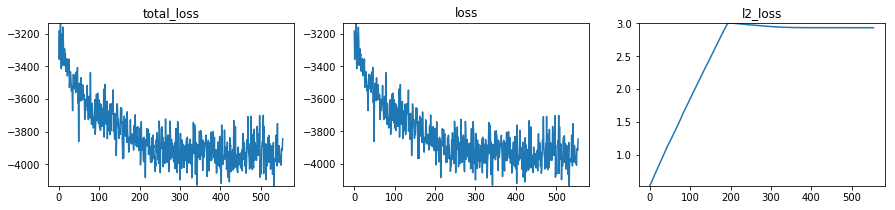

100%|██████████| 1000/1000 [01:36<00:00, 10.34it/s]


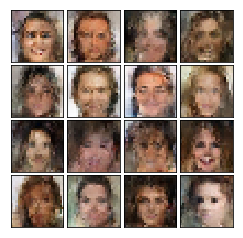

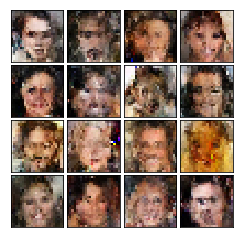

  5%|▌         | 51/1000 [00:04<01:20, 11.76it/s]

total_loss -3855.2288
loss -3858.1594
l2_loss 2.9306068


 10%|█         | 101/1000 [00:09<01:22, 10.85it/s]

total_loss -3941.512
loss -3944.4426
l2_loss 2.9306064


 15%|█▌        | 151/1000 [00:13<01:16, 11.15it/s]

total_loss -4102.03
loss -4104.9604
l2_loss 2.9306026


 20%|██        | 201/1000 [00:17<01:10, 11.31it/s]

total_loss -3808.3037
loss -3811.2344
l2_loss 2.9305973


 25%|██▌       | 251/1000 [00:22<01:05, 11.40it/s]

total_loss -4065.3665
loss -4068.297
l2_loss 2.9305906


 30%|███       | 301/1000 [00:26<01:00, 11.51it/s]

total_loss -3961.1099
loss -3964.0405
l2_loss 2.930587


 35%|███▌      | 351/1000 [00:30<00:56, 11.55it/s]

total_loss -3860.0488
loss -3862.9795
l2_loss 2.9305856


 40%|████      | 401/1000 [00:34<00:51, 11.60it/s]

total_loss -3993.191
loss -3996.1216
l2_loss 2.9305823


 45%|████▌     | 451/1000 [00:38<00:47, 11.65it/s]

total_loss -3991.0295
loss -3993.9602
l2_loss 2.930579


 50%|█████     | 501/1000 [00:43<00:42, 11.63it/s]

total_loss -3997.4468
loss -4000.3774
l2_loss 2.9305806


 55%|█████▌    | 551/1000 [00:47<00:38, 11.65it/s]

total_loss -4022.798
loss -4025.7288
l2_loss 2.9305835


 60%|██████    | 601/1000 [00:51<00:34, 11.68it/s]

total_loss -4062.3318
loss -4065.2625
l2_loss 2.9305873


 65%|██████▌   | 651/1000 [00:55<00:29, 11.70it/s]

total_loss -4074.2754
loss -4077.206
l2_loss 2.9305925


 70%|███████   | 701/1000 [00:59<00:25, 11.69it/s]

total_loss -3993.2563
loss -3996.187
l2_loss 2.9305942


 75%|███████▌  | 751/1000 [01:04<00:21, 11.67it/s]

total_loss -3952.9756
loss -3955.9062
l2_loss 2.930593


 80%|████████  | 801/1000 [01:08<00:17, 11.68it/s]

total_loss -4082.9727
loss -4085.9033
l2_loss 2.930586


 85%|████████▌ | 851/1000 [01:12<00:12, 11.69it/s]

total_loss -3957.1294
loss -3960.06
l2_loss 2.9305828


 90%|█████████ | 901/1000 [01:17<00:08, 11.70it/s]

total_loss -3907.2983
loss -3910.229
l2_loss 2.93058


 95%|█████████▌| 951/1000 [01:21<00:04, 11.71it/s]

total_loss -4007.6309
loss -4010.5615
l2_loss 2.9305792


100%|█████████▉| 999/1000 [01:25<00:00, 11.72it/s]

total_loss -3876.345
loss -3879.2756
l2_loss 2.930577


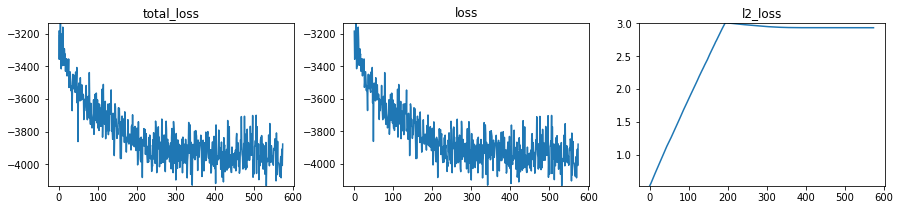

100%|██████████| 1000/1000 [01:25<00:00, 11.67it/s]


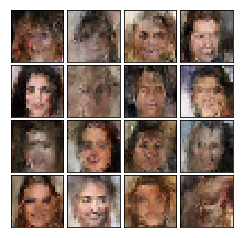

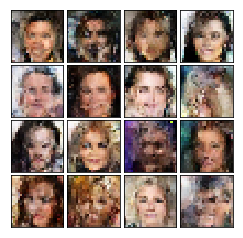

  5%|▌         | 52/1000 [00:04<01:20, 11.77it/s]

total_loss -3838.0884
loss -3841.019
l2_loss 2.9305735


 10%|█         | 102/1000 [00:08<01:15, 11.85it/s]

total_loss -3933.0835
loss -3936.0142
l2_loss 2.9305737


 15%|█▌        | 152/1000 [00:12<01:11, 11.89it/s]

total_loss -3796.4695
loss -3799.4001
l2_loss 2.9305792


 20%|██        | 202/1000 [00:17<01:07, 11.87it/s]

total_loss -4039.6365
loss -4042.5671
l2_loss 2.9305794


 25%|██▌       | 252/1000 [00:21<01:03, 11.80it/s]

total_loss -3907.1787
loss -3910.1094
l2_loss 2.9305854


 30%|███       | 302/1000 [00:25<00:59, 11.83it/s]

total_loss -3995.892
loss -3998.8228
l2_loss 2.9305897


 35%|███▌      | 352/1000 [00:29<00:54, 11.85it/s]

total_loss -3949.547
loss -3952.4778
l2_loss 2.930589


 40%|████      | 402/1000 [00:34<00:50, 11.80it/s]

total_loss -3891.0962
loss -3894.0269
l2_loss 2.9305887


 45%|████▌     | 452/1000 [00:38<00:46, 11.70it/s]

total_loss -3861.5552
loss -3864.4858
l2_loss 2.93058


 50%|█████     | 502/1000 [00:43<00:42, 11.63it/s]

total_loss -3794.686
loss -3797.6167
l2_loss 2.9305756


 55%|█████▌    | 552/1000 [00:47<00:38, 11.53it/s]

total_loss -4011.0786
loss -4014.0093
l2_loss 2.9305727


 60%|██████    | 602/1000 [00:52<00:34, 11.48it/s]

total_loss -3895.0483
loss -3897.979
l2_loss 2.930574


 65%|██████▌   | 652/1000 [00:57<00:30, 11.44it/s]

total_loss -4107.5547
loss -4110.4854
l2_loss 2.9305744


 70%|███████   | 702/1000 [01:01<00:26, 11.40it/s]

total_loss -3802.2678
loss -3805.1985
l2_loss 2.9305701


 75%|███████▌  | 752/1000 [01:06<00:21, 11.35it/s]

total_loss -4015.705
loss -4018.6357
l2_loss 2.9305725


 80%|████████  | 802/1000 [01:10<00:17, 11.32it/s]

total_loss -3991.166
loss -3994.0967
l2_loss 2.9305763


 85%|████████▌ | 852/1000 [01:15<00:13, 11.31it/s]

total_loss -3923.4297
loss -3926.3604
l2_loss 2.9305828


 90%|█████████ | 902/1000 [01:19<00:08, 11.32it/s]

total_loss -3894.9453
loss -3897.876
l2_loss 2.9305851


 95%|█████████▌| 952/1000 [01:23<00:04, 11.34it/s]

total_loss -3835.4617
loss -3838.3923
l2_loss 2.930589


100%|█████████▉| 999/1000 [01:28<00:00, 11.30it/s]

total_loss -4138.3906
loss -4141.3213
l2_loss 2.9305897


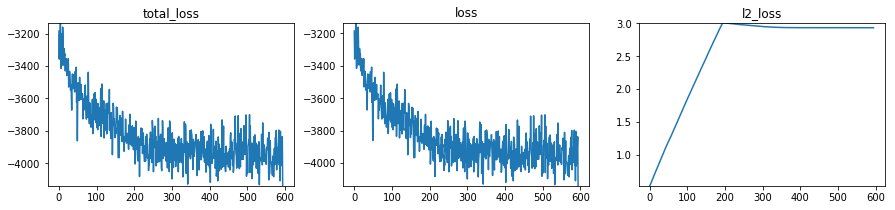

100%|██████████| 1000/1000 [01:28<00:00, 11.25it/s]


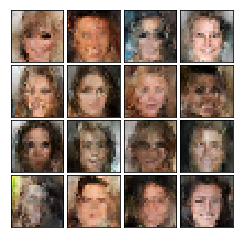

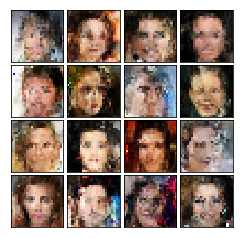

In [35]:
for i in range(10):
    utils.trainer(
        sess, 
        num_steps=1000, 
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.00001, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.9})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()

In [46]:
grid_image = tf.contrib.gan.eval.image_grid(
    x_flow_sampled,
    grid_shape=[4, batch_size // 4],
    image_shape=(image_size, image_size),
    num_channels=3
)

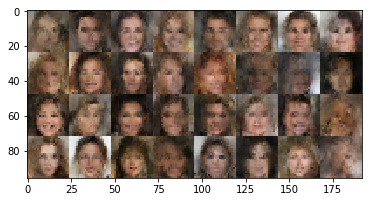

In [48]:
plt.imshow(grid_image[0].eval({lr_ph: 0.0, beta_ph: 0.8}))

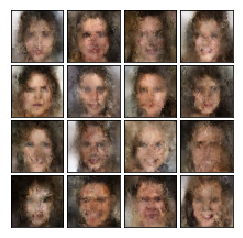

In [34]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.8})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.001

100%|█████████▉| 999/1000 [03:02<00:00,  5.46it/s]

total_loss -19185.404
loss -19185.79
l2_loss 0.38562733


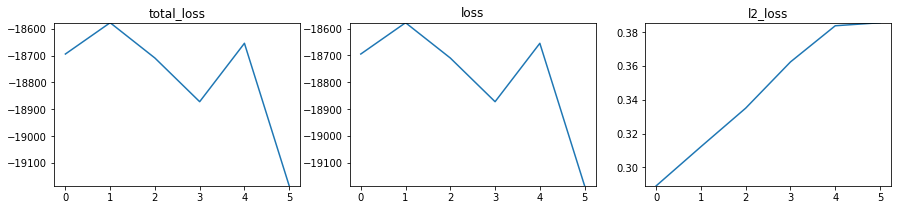

100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


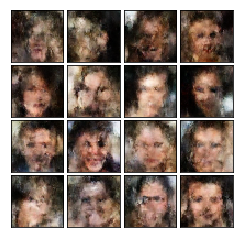

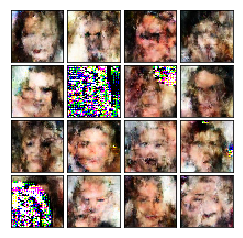

100%|█████████▉| 999/1000 [03:03<00:00,  5.44it/s]

total_loss -19483.15
loss -19483.533
l2_loss 0.38338688


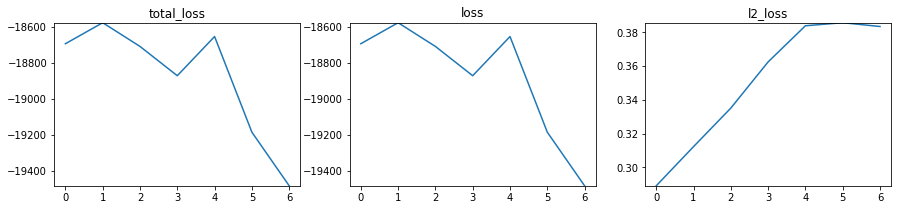

100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


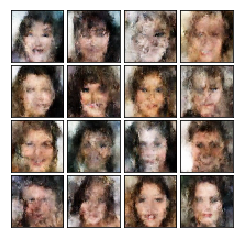

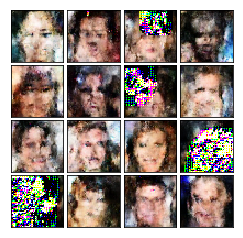

100%|█████████▉| 999/1000 [02:38<00:00,  6.31it/s]

total_loss -19590.39
loss -19590.775
l2_loss 0.3845714


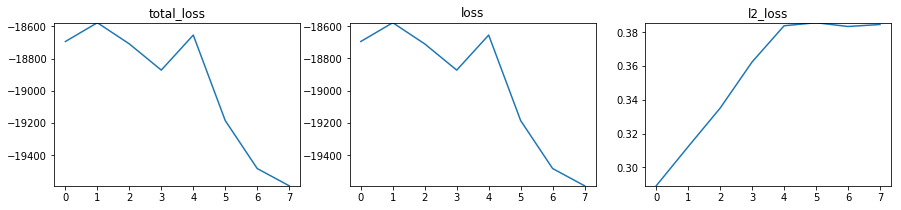

100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s]


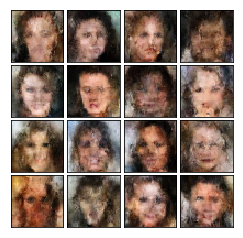

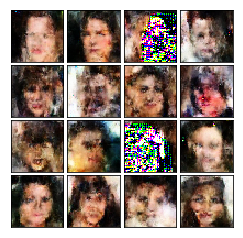

 96%|█████████▋| 965/1000 [03:08<00:06,  5.12it/s]

KeyboardInterrupt: 

In [31]:
for i in range(20):
    utils.trainer(
        sess, 
        num_steps=1000, 
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.001, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.9})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()

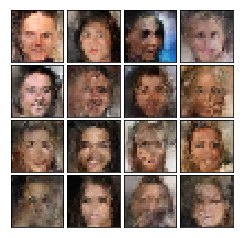

In [42]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.9})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.0001

In [ ]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

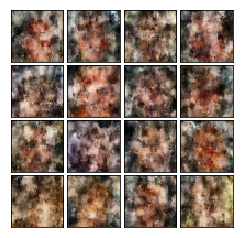

In [49]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.9})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Long train ...

In [ ]:
utils.trainer(
    sess, 
    num_steps=100000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

  0%|          | 100/100000 [00:10<2:50:12,  9.78it/s]

total_loss -2515.47
loss -2517.224
l2_loss 1.7541755


  0%|          | 189/100000 [00:19<2:51:03,  9.73it/s]

## Generate samples for different temperatures

We start from zero T i.e. the input standard deviation is zero. We can see simialar 
conclusion as in paper, sampling from reduced temperature yield in better results.

In [105]:
for beta in np.linspace(0.0, 1.5, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: beta})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    

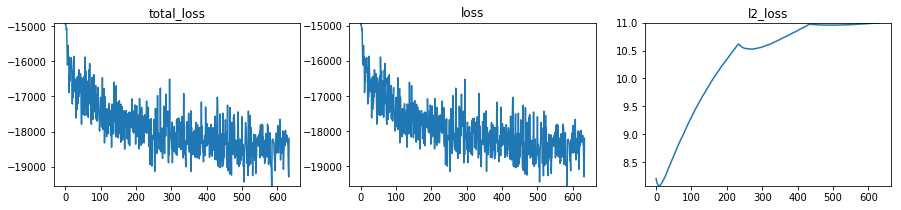

In [50]:
plot_metrics_hook.run()

## Investigate latent space statistics
Check whether the distribution of the latent variables fits the prior distribution. We should observe gaussian

In [35]:
y_flatten_np = np.concatenate([y_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
y_flatten_np.shape

(3200, 432)

### 2D scatter plot for 0-th and 1-st latent variable

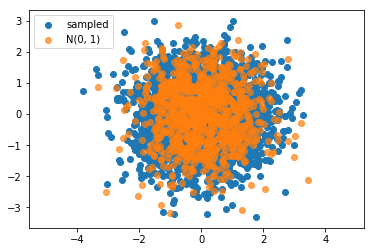

In [36]:
plt.scatter(y_flatten_np[:, 0], y_flatten_np[:, 1], label="sampled")
plt.scatter(*np.random.randn(2, 1000), alpha=0.7, label="N(0, 1)")
plt.axis("equal")
plt.legend()

### Histogram of all activations of Y latent variable

(-4, 4)

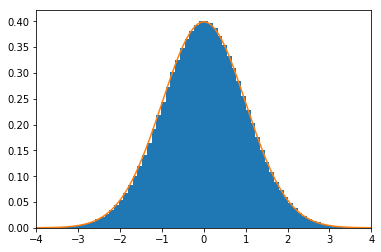

In [37]:
_ = plt.hist(y_flatten_np.reshape([-1]), 100, normed=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

### Histogram of all activations of Z latent variable

(-4, 4)

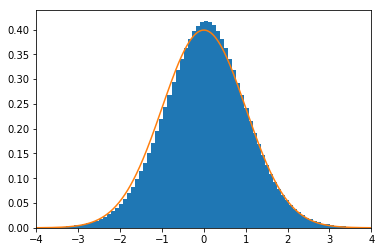

In [38]:
z_flatten_np = np.concatenate([z_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
_ = plt.hist(z_flatten_np.reshape([-1]), 200, normed=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

## Tuning temperature separatelly for Y and Z latent variables

This seems to generate the best results when the temperature of the distribution of the Z variable is close 
or equal zero. 

In [39]:
beta_y_ph = tf.placeholder(tf.float32, [])
beta_z_ph = tf.placeholder(tf.float32, [])
prior_y_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(y_flatten), scale_diag=beta_y_ph * tf.ones_like(y_flatten))
prior_z_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(z_flatten), scale_diag=beta_z_ph * tf.ones_like(z_flatten))

In [40]:
sample_y_flatten_prim = prior_y_prim.sample()
sample_y_prim = tf.reshape(sample_y_flatten_prim, y.shape.as_list())
sample_z_prim = tf.reshape(prior_z_prim.sample(), z.shape.as_list())
sampled_logdet_prim = prior_y_prim.log_prob(sample_y_flatten_prim)

In [41]:
inverse_flow_prim = sample_y_prim, sampled_logdet_prim, sample_z_prim
sampled_flow_prim = model_flow(inverse_flow_prim, forward=False)

FactorOutLayer/Backward/Scale4          : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ChainLayer/Backward/Step8               : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 96]	z=[32, 3, 3, 672]	logdet=[32]
ActnormBiasLayer/Back

AffineCouplingLayer/Backward/           : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ChainLayer/Backward/Step3               : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 6, 6, 48]	z=[32, 6, 6, 144]	logdet=[32]
ChainLayer/Backward/ 

AffineCouplingLayer/Backward/           : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ChainLayer/Backward/Step7               : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 24, 24, 12]	z=[32, 24, 24, 0]	logdet=[32]

In [42]:
x_flow_sampled_prim, _, _ = sampled_flow_prim

### Efect of the temperature on the Z latent variable

beta=    0.0000


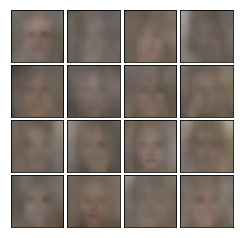

beta=    0.1111


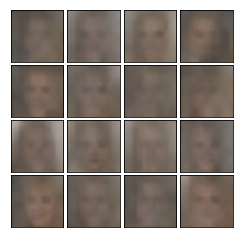

beta=    0.2222


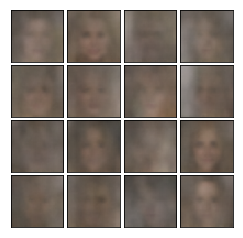

beta=    0.3333


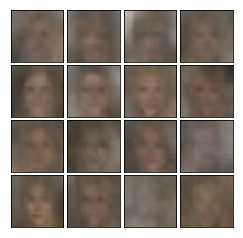

beta=    0.4444


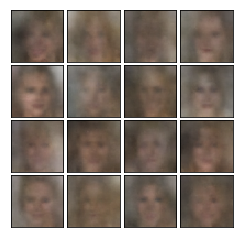

beta=    0.5556


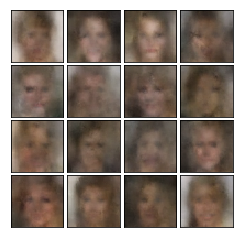

beta=    0.6667


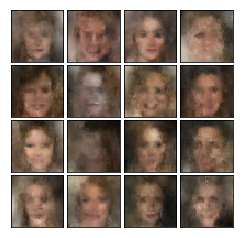

beta=    0.7778


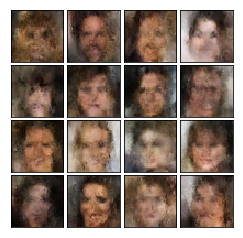

beta=    0.8889


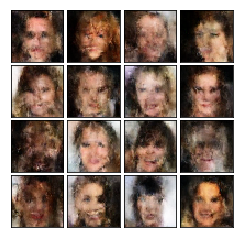

beta=    1.0000


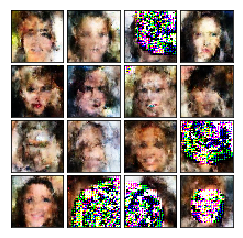

In [43]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: 1.0, 
            beta_z_ph: beta
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    

### Efect of the temperature on the Y latent variable when beta_z=0.1

beta=    0.0000


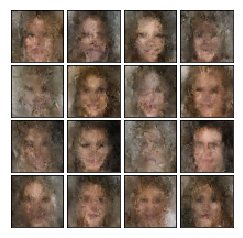

beta=    0.1111


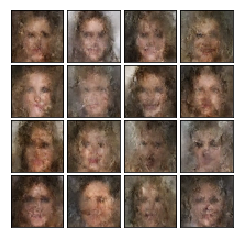

beta=    0.2222


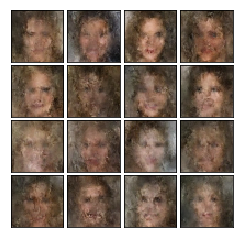

beta=    0.3333


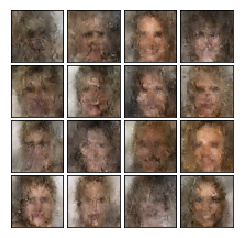

beta=    0.4444


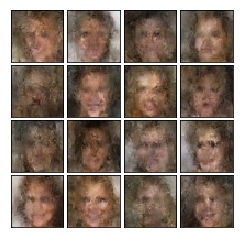

beta=    0.5556


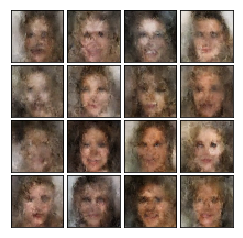

beta=    0.6667


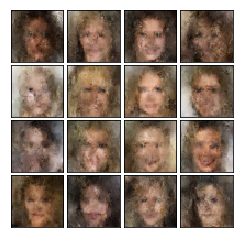

beta=    0.7778


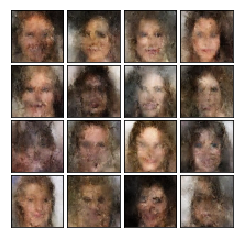

beta=    0.8889


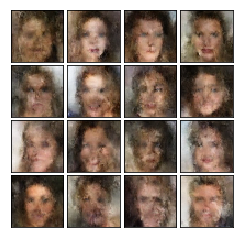

beta=    1.0000


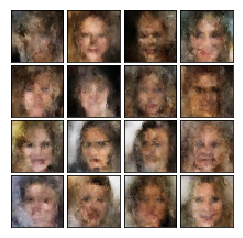

In [46]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: beta, 
            beta_z_ph: 0.8
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    